# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [426]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/peterefimov/Skillfactory_basic_python_course_Efimov/real_estate_data.csv', sep='\t')

#Оцениваем внешний вид данных в начальном виде
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

#### Вывод по шагу 1

Таблица с данными в начальной форме импортирована и прочитана.

### Шаг 2. Предобработка данных

Для просмотра информации о данных и определения количества нулевых значений пользуемся методом info. Дополнительно проверим данные на наличие дубликатов.

In [427]:
print(data.info())
print()
print(f'Всего полных дубликатов: {data.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Пропущенные значения обнаружили в большинстве данных, а именно в следующих столбцах:
1. Высота потолка
2. Общее количество этажей в доме
3. Жилая площадь
4. Является ли недвижимость апартаментами
5. Площадь кухни
6. Количество балконов
7. Название района
8. Расстояние до ближайшего аэропорта
9. Расстояние до центра города
10. Число парков в радиусе 3 км
11. Расстояние до ближайшего парка
12. Число водоёмов в радиусе 3 км
13. Расстояние до ближайшего водоёма
14. Число дней активности объявления

#### Балконы

Пропуск в данном столбце будем считать фактическим отсутствием балконов, то есть неслучайным пропуском.

In [428]:
#Заменим пропущенные значения на 0 методом fillna
data['balcony'] = data['balcony'].fillna(0)

#проверим, что нет иных уникальных значений, кроме нормального числа балконов
print(data['balcony'].unique())

[0. 2. 1. 5. 4. 3.]


#### Апартаменты

Данные о том, является ли квартира апартаментами, заполнены лишь в 2775 случаях из 23699, то есть почти 90% пропусков. Однако, зависимость от того, является ли недвижимость апартаментами или нет не входит в цели данного исследования. Таким образом, можем предположить, что все неуказанные недвижимости апартаментами не являются - обычные жилые квартиры. Заменим пропуски на False и заодно переведём формат из object в bool.

In [429]:
print(data['is_apartment'].value_counts())
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'] = data['is_apartment'].astype('bool')
print()
print('После преобразования')
print()
print(data['is_apartment'].value_counts())

False    2725
True       50
Name: is_apartment, dtype: int64

После преобразования

False    23649
True        50
Name: is_apartment, dtype: int64


Получается так, что все квартиры с пропусками мы сочли не являющимися апартаментами. С одной стороны, это не совсем корректно, с другой стороны, при изначально заполненном параметре только в 10% случаев проводить какой-либо анализ этого параметра было бы бессмысленно. Следует изучить, каким образом проводился сбор данных по этому параметру и сообщить автору данных.

#### Парки и водоёмы в радиусе 3000 м

Пропуски количества парков и водоёмов можно также считать фактическим отсутствием парков и водоёмов в радиусе 3000 м от недвижимости. Заменим пропущенные значения на нули.

In [430]:
#Заменим пропущенные значения на 0 методом fillna
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

#проверим, что нет иных уникальных значений, кроме нормального числа парков и водоёмов
print(data['parks_around3000'].unique())
print(data['ponds_around3000'].unique())

[1. 0. 2. 3.]
[2. 0. 3. 1.]


#### Количество дней публикации объявления

Этот пропуск может быть объяснён ошибкой при расчёте количества дней или при сборе данных в датасет. Данные отсутствуют в ~13% случаев. Считаю возможным заменить пропущенные значения на медиану.

In [431]:
# data['days_exposition'].hist()
# print(data['days_exposition'].mean())
# print(data['days_exposition'].median())

# days_median = data['days_exposition'].median()
# print(days_median)
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

#### Проверка названий населённых пунктов

Проверим адекватность заполнения названий населённых пунктов. Сперва визуально.

In [432]:
print(data['locality_name'].unique())
# print(len(data['locality_name'].unique()))
# data['locality_name'] = data['locality_name'].str.lower()
# print(len(data['locality_name'].unique()))
# print((data['locality_name'].unique()))


['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Очевидных ошибок и дубликатов в этом столбце не видно. Проверим наличие скрытых дубликатов опустив регистр и посчитав количество уникальных значений.

In [433]:
print(len(data['locality_name'].unique()))
# data_processing['locality_name'] = data['locality_name'].str.lower()
# print(len(data['locality_name'].unique()))
# print((data['locality_name'].unique()))

365


Число уникальных значений при изменении регистра шрифта не изменилось, Закомментируем проверку, чтобы сохранить начальный вид данных.

#### Высота потолков, этажность, удалённость от центра, парков, водоёмов и аэропорта

Эти пропуски носят случайный характер - либо не были внесены при сборе информации, либо ошибочно пропали при генерации. Эти данные связаны с локацией недвижимости - в районе одна удалённость от центра и аэропорта, а также можно предположить примерно одинаковую этажность зданий и высоту потолков в домах одной локации. Таким образом, эти пропуски можно заполнить, привязавшись к локации.

Составим таблицы с медианами этих значений, сгруппировав по району.

In [434]:
data['locality_name'].fillna('unk', inplace=True)

local_ceiling_height = data.groupby('locality_name')['ceiling_height'].median().to_dict()
local_airports_nearest = data.groupby('locality_name')['airports_nearest'].median().to_dict()
local_cityCenters_nearest = data.groupby('locality_name')['cityCenters_nearest'].median().to_dict()
local_floors_total = data.groupby('locality_name')['floors_total'].median().to_dict()
local_parks_nearest = data.groupby('locality_name')['parks_nearest'].median().to_dict()
local_ponds_nearest = data.groupby('locality_name')['ponds_nearest'].median().to_dict()

data['ceiling_height'].fillna(-1, inplace=True)
data['airports_nearest'].fillna(-1, inplace=True)
data['cityCenters_nearest'].fillna(-1, inplace=True)
data['floors_total'].fillna(-1, inplace=True)
data['parks_nearest'].fillna(-1, inplace=True)
data['ponds_nearest'].fillna(-1, inplace=True)

def ceiling_height_mapper(row):
    if row['ceiling_height'] == -1:
        return local_ceiling_height[row['locality_name']]
    return row['ceiling_height']

def airports_nearest_mapper(row):
    if row['airports_nearest'] == -1:
        return local_airports_nearest[row['locality_name']]
    return row['airports_nearest']

def cityCenters_nearest_mapper(row):
    if row['cityCenters_nearest'] == -1:
        return local_cityCenters_nearest[row['locality_name']]
    return row['cityCenters_nearest']

def floors_total_mapper(row):
    if row['floors_total'] == -1:
        return local_floors_total[row['locality_name']]
    return row['floors_total']

def parks_nearest_mapper(row):
    if row['parks_nearest'] == -1:
        return local_parks_nearest[row['locality_name']]
    return row['parks_nearest']

def ponds_nearest_mapper(row):
    if row['ponds_nearest'] == -1:
        return local_ponds_nearest[row['locality_name']]
    return row['ponds_nearest']

data['ceiling_height'] = data.apply(ceiling_height_mapper, axis=1)
data['airports_nearest'] = data.apply(airports_nearest_mapper, axis=1)
data['cityCenters_nearest'] = data.apply(cityCenters_nearest_mapper, axis=1)
data['floors_total'] = data.apply(floors_total_mapper, axis=1)
data['parks_nearest'] = data.apply(parks_nearest_mapper, axis=1)
data['ponds_nearest'] = data.apply(ponds_nearest_mapper, axis=1)

# Проверим, как изменилось количество нулевых значений
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23578 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Всё равно остались пропуски в некоторых столбцах. Это вызвано тем, что в отдельных жилых районах столбцы пустые полностью, поэтому медиана из nan получается тоже равной nan. В тех случаях, где их количество незначительно, заменим медианой. В прочих случаях оставим пустые значения неизменными, т.к. попытка из принудительно заменить на какую-то расчётную величину может испортить общую картину. Тем более их количество уже снизилось.

In [435]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

Таким образом оставляем пропуски в следующих столбцах:
1. Апартаменты
2. Расстояние до парков
3. Расстояние до аэропортов
4. Расстояние до центра
5. Расстоние до водоёма

Позже заменим пропуски в столбцах "площадь кухни" и "жилая площадь", когда рассчитаем соотношение площади к кухне. 

#### Замена типов данных

Требуется заменить некоторые значения float на int в тех случаях, где значения могут быть только целыми числами, и object на datetime в столбце, где указана дата публикации объявления. Это пригодится для дальнейшей работы с данными.

In [436]:
# first_day_exposition
# floors_total
# is_apartment
# balcony
# parks_around3000
# ponds_around3000
# days_exposition

data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')

data['is_apartment'] = data['is_apartment'].fillna(-1)
data['is_apartment'] = data['is_apartment'].astype('bool')

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Вывод по шагу 2

Пропуски заполнены, типы данных заменены. Осталось дозаполнить пропуски в жилой площади и площади кухни.

### Шаг 3. Посчитайте и добавьте в таблицу

#### Цена квадратного метра

In [437]:
# Создаём требуемый столбец, разделив цену на общую площадь квартиры
data['sqm_price'] = data['last_price'] / data['total_area']

#### День недели, месяц и год публикации

In [438]:
# Выделим день недели, месяц и год из столбца с датой размещенияя объявления
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#### Этаж квартиры

In [439]:
# Напишем функцию, группирующую квартиры по этажам и добавим в новый столбец

def floor_definer(row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    else:
        return 'Другой'

data['floor_group'] = data.apply(floor_definer, axis=1)

#### Cоотношение жилой и общей площади, отношение площади кухни к общей

In [440]:
# Разделим площадь кухни и жилую площадь на общую, получим требуемые отношения

data['living_to_total'] = data['living_area'] / data['total_area']
data['kitchen_to_total'] = data['kitchen_area'] / data['total_area']

# Посмотрим на результат добавления столбцов
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
0            2.70            16         51.0      8         False  ...   
1            2.63            11         18.6      1         False  ...   
2            2.70             5         34.3      4         False  ...   
3            2.70            14          NaN      9         False  ...   
4            3.03            14         32.0     13         False  ...   

   ponds_around3000  ponds_nearest  days_exposition      sqm_price weekday  \
0                 2          755.0               9

Теперь есть возможность достаточно релевантно заполнить пропуски в столбцах жилой площади и площади кухни.

In [441]:
# Заполним пропуски в столбцах отношения жилой площади и площади кухни к общей площади.
# Заменим медианой, т.к. в данном случае это видится наиболее релевантным вариантом.
# Посчитаем медианы отдельно, т.к. они понадобятся далее

median_living_to_total = data['living_to_total'].median()
median_kitchen_to_total = data['kitchen_to_total'].median()

# Заполним пропуски в отношениях

data['living_to_total'] = data['living_to_total'].fillna(median_living_to_total)
data['kitchen_to_total'] = data['kitchen_to_total'].fillna(median_kitchen_to_total)

# Теперь заменим пропуски в площадях на -1

data['living_area'].fillna(-1, inplace=True)
data['kitchen_area'].fillna(-1, inplace=True)

# Пишем функции, которые при обнаружении пропуска (-1) в площадях вычислят предполагаемую площадь, 
# умножив медиану отношения площадей на общую площадь

def living_mapper(row):
    if row['living_area'] == -1:
        new_value = median_living_to_total * row['living_area']
        return new_value
    return row['living_area']

def kitchen_mapper(row):
    if row['kitchen_area'] == -1:
        new_value = median_kitchen_to_total * row['kitchen_area']
        return new_value
    return row['kitchen_area']

# Применяем полученные функции к столбцам с площадями

data['living_area'] = data.apply(living_mapper, axis=1)
data['kitchen_area'] = data.apply(living_mapper, axis=1)

# Проверим успешность заполнения пропусков

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

#### Вывод по шагу 3

Добавлены новые значения согласно заданию, окончательно заполнены пропуски там, где это возможно и где имеет смысл.

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Вот, это верно - здравый смысл во всём))
<br>
</font>

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Изучим параметры - площадь, цена, число комнат, высота потолков

Построим гистограммы для параметров,предварительно определив минимальные и максимальные значения для определения визуальных границ гистограмм

#### Площадь недвижимости

In [442]:
# В данном этапе применяю ручное построение графиков и индивидуальную оценку каждого параметра без циклов.
# На мой взгляд, это поможет более осознанно отсечь выбивающиеся параметры.

# Для площади определим максимальное и минимальное значение для понимания границ гистограммы:
print(data['total_area'].min())
print(data['total_area'].max())

12.0
900.0


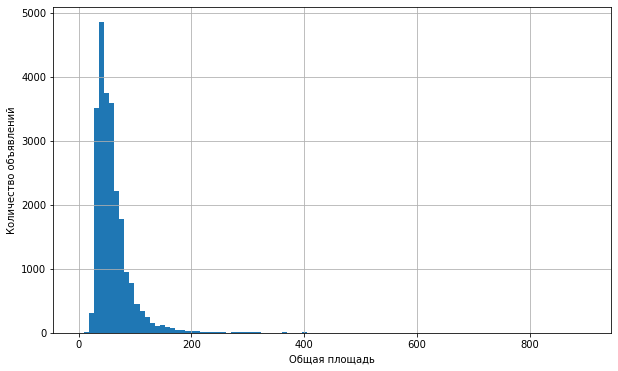

In [443]:
# Строим гистограмму площадей. 
data['total_area'].hist(bins=100, range=(0,900), figsize=(10,6))
plt.xlabel('Общая площадь')
plt.ylabel('Количество объявлений')
plt.show()

Видим значительно выбивающиеся значения в большую сторону. Оценим их количество методом boxplot.
Минимальное же значение в 12 кв. м вопросов не вызывает - это реальная площадь некоторых жилых студий.

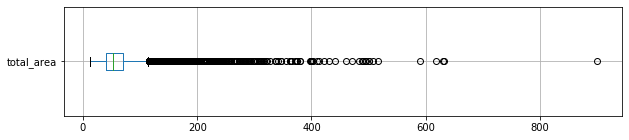

In [444]:
data.boxplot(column='total_area',vert=False,figsize=(10,2))
plt.show()

По гистограмме и боксплоту видим, что значения площади более 300 кв. м значительно выделаются из общего распределения. Предположим, что такие квартиры - высшая точка рынка, в которой зависимости, присущие обычным предложениям, вряд ли действуют. Проверим, можем ли мы от них избавиться - оценим масштаб потери. Будем считать, что потеря до 5% данных допустима.

In [445]:
# Посмотрим, сколько всего таких объявлений
print(len(data.query('total_area > 300')))

# Оценим процент таких объявлений от общего числа
print(len(data.query('total_area > 300')) / len(data))

61
0.0025739482678594034


Если мы уберём эти значения, потеряем 0.25% начальных данных, что допустимо. Применим метод query. Введём переменную data_filt,  в которой далее будем хранить отфильтрованные данные. Обновлять её будем последовательно с каждой итерацией, чтобы не создавать излишнее количество переменных.

In [446]:
data_filt = data.query('total_area <= 300')

Теперь обновим гистограмму площадей

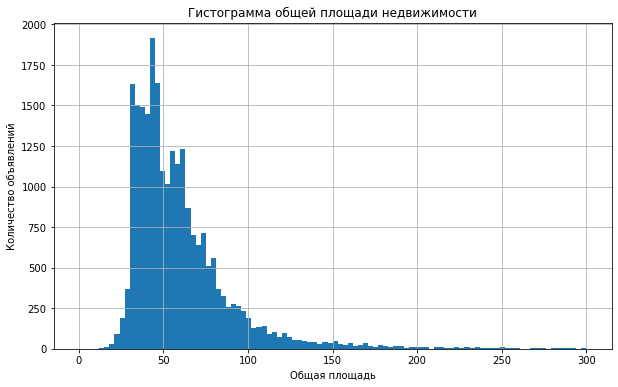

In [447]:
data_filt['total_area'].hist(bins=100, range=(0,300), figsize=(10,6))
plt.title('Гистограмма общей площади недвижимости')
plt.xlabel('Общая площадь')
plt.ylabel('Количество объявлений')
plt.show()

Получили распределение, напоминающее распределение Пуассона. Минимальную площадь имеют единичные студии от 12 м2, наиболее распространены площади от 30 до 50 м2, от 50 до 70, что можно соотнести с популяярностью 1 и 2-комнатных квартир, меньшей популярностью пользуются квартиры от 70 м2, далее с ростом площади количество объявлений стремится к нулю.

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
В общем, мы видим, что гистограмма имеет так называемую двугорбость (трёхгорбость...)<br>
Это когда в одной выборке данных, присутствуюет несколько выборк. В данном случа: однушки, двушки и т.д.
<br>
</font>

#### Цена квартиры

In [448]:
# Определим максимальную и минимальную цену:
print(data_filt['last_price'].min())
print(data_filt['last_price'].max())

12190.0
330000000.0


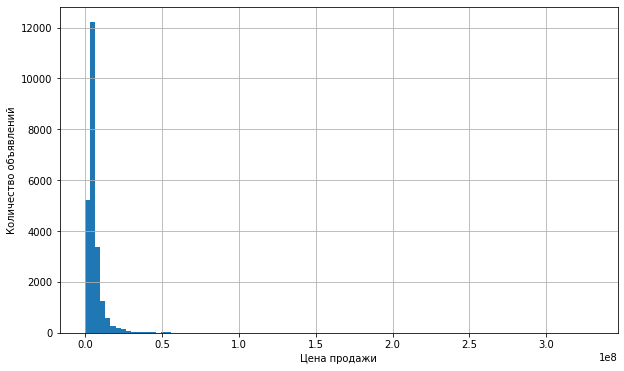

In [449]:
# Строим гистограмму цены. 
data_filt['last_price'].hist(bins=100, range=(0,330000000.0), figsize=(10,6))
plt.xlabel('Цена продажи')
plt.ylabel('Количество объявлений')
plt.show()

В данном случае, очевидно, нужно изучить правый край распределения, т.к. явно выбивающиеся из общего распределения значения портят картину.

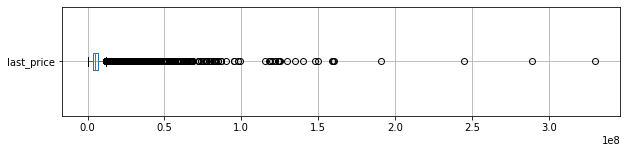

In [450]:
data_filt.boxplot(column='last_price',vert=False,figsize=(10,2))
plt.show()

Проверим верхнюю границу в 30 млн руб.

In [451]:
# Посмотрим, сколько всего таких объявлений
print(len(data_filt.query('last_price > 30000000')))

# Оценим процент таких объявлений от общего числа
print(len(data_filt.query('last_price > 30000000')) / len(data))

267
0.01126629815604034


Теряем менее 1% данных, что допустимо. Применим срез.

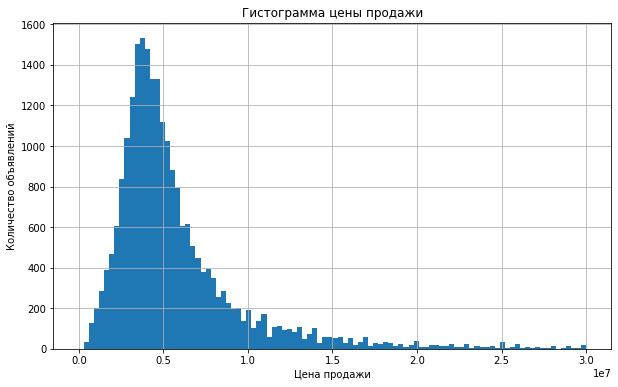

In [452]:
data_filt = data_filt.query('last_price <= 30000000')

# Далее строим гистограмму цены. 
data_filt['last_price'].hist(bins=100, range=(0,30000000), figsize=(10,6))
plt.title('Гистограмма цены продажи')
plt.xlabel('Цена продажи')
plt.ylabel('Количество объявлений')
plt.show()

Получили более наглядное распределение. Минимальная цена может соответствовать комнате в отдалённой деревне, середина располагается от 1 млн руб. с пиком в районе 4 млн руб. и со снижением предложений до 10 млн руб., дальнейшие объявления по цене единичны.

#### Количество комнат

In [453]:
# Определим максимальное и минимальное количество:
print(data_filt['rooms'].min())
print(data_filt['rooms'].max())

0
16


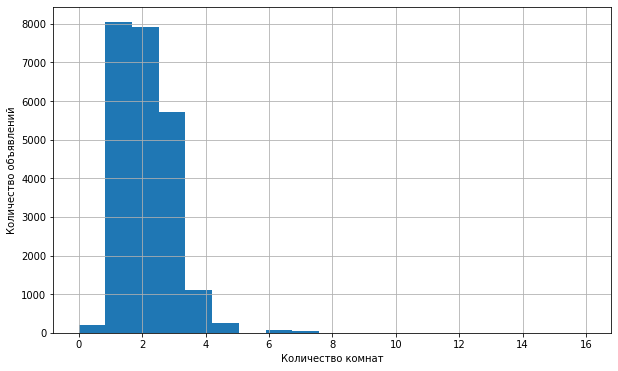

In [454]:
# Строим гистограмму количества комнат
data_filt['rooms'].hist(bins=19, range=(0,16), figsize=(10,6))
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.show()

Оценим правый край гистограммы:

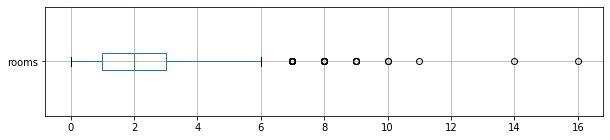

In [455]:
data_filt.boxplot(column='rooms',vert=False,figsize=(10,2))
plt.show()

In [456]:
print(len(data_filt.query('rooms > 7')))
print(len(data_filt.query('rooms > 7')) / len(data))

15
0.0006329380986539516


Мы можем убрать объявления с количеством комнат более 7, т.к. скорее всего они выбиваются из общих распределений. Потеря данных много менее 1%.

In [457]:
data_filt = data_filt.query('rooms <= 7')

Насчёт объявлений с количеством комнат, равным 0. Скорее всего это относится к квартирам со свободной планировкой и студиям. Оставим их без изменения.

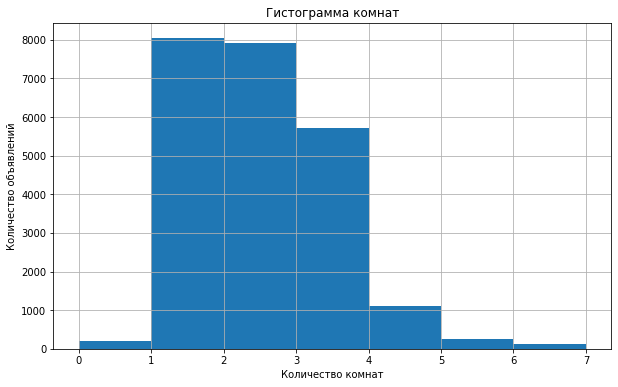

In [458]:
# Строим гистограмму количества комнат
data_filt['rooms'].hist(bins=7, range=(0,7), figsize=(10,6))
plt.title('Гистограмма комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объявлений')
plt.show()

Видно, что практически одинаковой популярностью пользуются 1- и 2-комнатные квартиры, менее популярны 3-комнатные, а студии, свободные планировки и варианты с 4 и более комнатами на рынке представлены значительно меньше.

#### Высота потолков

In [459]:
# Определим максимальную и минимальную высоту потолков:
print(data_filt['ceiling_height'].min())
print(data_filt['ceiling_height'].max())

1.0
100.0


Сразу построим боксплот, т.к. потолки в 1 и 100 м крайне подозрительны.

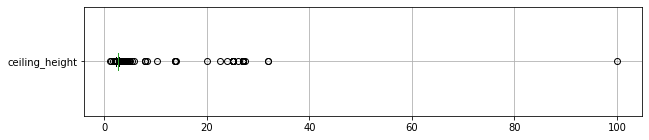

In [460]:
data_filt.boxplot(column='ceiling_height',vert=False,figsize=(10,2))
plt.show()

Согласно САНПИНу минимальна высота потолков в холлах и коридорах 1.8 метра. Ограничим значения снизу значением 1.7 метра, сверху - 5 метрами, т.к. это видно по боксплоту.

In [461]:
# проверим их количество:
print(len(data_filt.query('ceiling_height < 1.7 or ceiling_height > 5')))
print(len(data_filt.query('ceiling_height < 1.7 or ceiling_height > 5')) / len(data))

37
0.0015612473100130807


Ограничения адекватны, отбросим выбивающиеся значения.

In [462]:
data_filt = data_filt.query('1.7 <= ceiling_height <= 5')

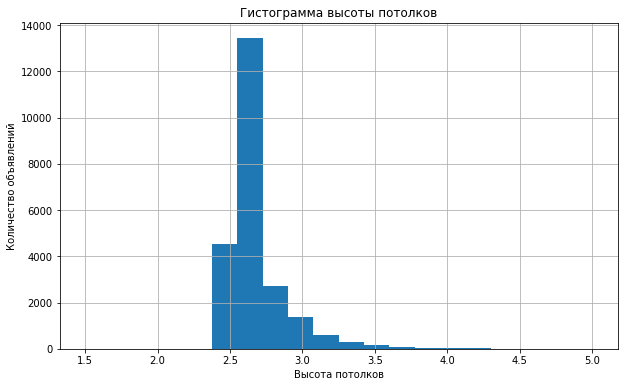

In [463]:
# Строим гистограмму высоты потолков.

data_filt['ceiling_height'].hist(bins=20, range=(1.5,5), figsize=(10,6))
plt.title('Гистограмма высоты потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество объявлений')
plt.show()

Получили ожидаемое распределение, совпадающее с реальной ситуацией с высотами потолков квартир - минимальная распространённая высота составляет 2.5 метра, пик приходится на "стандартные" 2.7 метра, реже встречаются высоты в районе 3 м и выше.

#### Изучим время продажи квартиры

Определим медиану и среднее значение:

In [464]:
median_days_exp = data_filt['days_exposition'].median()
mean_days_exp = data_filt['days_exposition'].mean()
minim_days_exp = data_filt['days_exposition'].min()
maxim_days_exp = data_filt['days_exposition'].max()

print(f'Медиана: {median_days_exp}')
print(f'Среднее значение: {mean_days_exp}')
print(f'Минимальное число дней в продаже: {minim_days_exp}')
print(f'Максимальное число дней в продаже: {maxim_days_exp}')

Медиана: 95.0
Среднее значение: 168.19511985934216
Минимальное число дней в продаже: 1
Максимальное число дней в продаже: 1580


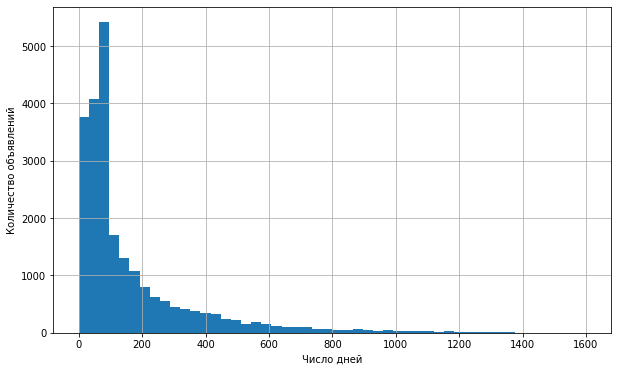

In [465]:
data_filt['days_exposition'].hist(bins=50, range=(0,1600), figsize=(10,6))
plt.xlabel('Число дней')
plt.ylabel('Количество объявлений')
plt.show()

Получили распределение, близкое к распределению Пуассона. Заметно, что значительное количество квартир продаются в течение нескольких дней публикации, достигая пика в районе 100 дней, далее идёт плавное снижение, и после 200 дней публикации объявления единичны. Воспользуемся методом boxplot, чтобы определить аномально долгие объявления.

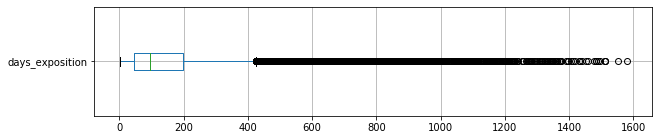

In [466]:
data_filt.boxplot(column='days_exposition',vert=False,figsize=(10,2))
plt.show()

Обнаружили, что объявления со сроком жизни более 400 дней выпадают из границ "ящика", то есть можно предположить, что от них можно избавиться. Оценим их количество.

In [467]:
print(len(data_filt.query('days_exposition > 400')))

2559


Получается значительное число, около 10% данных. Потеря такого количества данных может повлиять на результат исследования. Сделаем предположение, что адекватный срок жизни "живого" объявления вряд ли превысит 2 года (или 730 дней). Оценим их количество.

In [468]:
print(len(data_filt.query('days_exposition > 730')))

# Оценим процент таких объявлений от общего числа
print(len(data_filt.query('days_exposition > 730')) / len(data))

724
0.030549812228364066


Потеря данных составит около 3%. Это больше, чем при предыдущих сокращениях, однако релевантность объявления, размещённого более чем на 2 года, в рамках данного исследования сомнительна. Можно предположить, что оно либо перестало быть интересным автору, либо квартира уже продано, а объявление забыто, либо присутствует ошибка в сборе данных или ведении статистики срока жизни объявлений. С этим можно обратиться к автору данных.

Сократим данные:

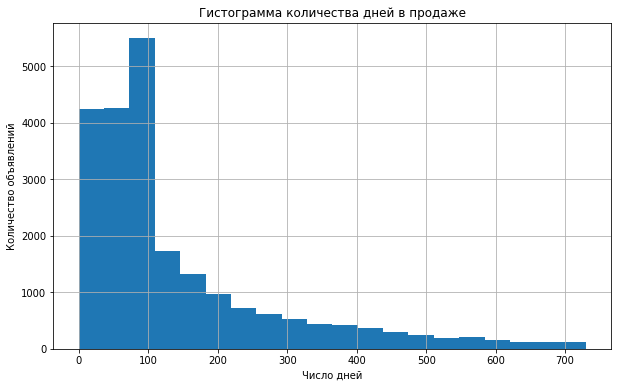

In [469]:
data_filt = data_filt.query('days_exposition <= 730')
data_filt['days_exposition'].hist(bins=20, range=(0,730), figsize=(10,6))
plt.title('Гистограмма количества дней в продаже')
plt.xlabel('Число дней')
plt.ylabel('Количество объявлений')
plt.show()

Получили распределение Пуассона. Большая часть квартир продаётся в течение первых 4 месяцев публикации, далее количество объявлений снижается. Несколько подозрительным кажется большое количество объявлений, снятых с публикации в первые же дни. Вряд ли все они были проданы с первые же дни обычным способом. Возможны варианты: объявление размещено случайно, снято для редактирования, повлияло участие посредников. Однако, возможно, эти продажи настоящие. В реальной ситуации требуется консультация с предоставившим данные о природе таких случаев. Так как в данном случае информации для принятия решения об их исключении недостаточно, оставляем как есть.

### Вывод по изученным параметрам

По пройденному этапу можно сделать следующие выводы:
1. Наиболее распространены квартиры общей площадью от 25 до 100 м2.
2. Основная масса квартир укладывается в 10 млн руб. со средним значением около 4 млн руб.
3. Самые популярные 1- и 2-комнатные квартиры, далее следуют 3-комнатные.
4. Наиболее распространены квартиры с потолками высотой стандартные 2.7 м.
5. Большинство объявлений снимаются с публикациии в течение 4 месяцев с момента размещения.

### Зависимость цены от различных факторов

#### Зависимость цены от площади квартиры

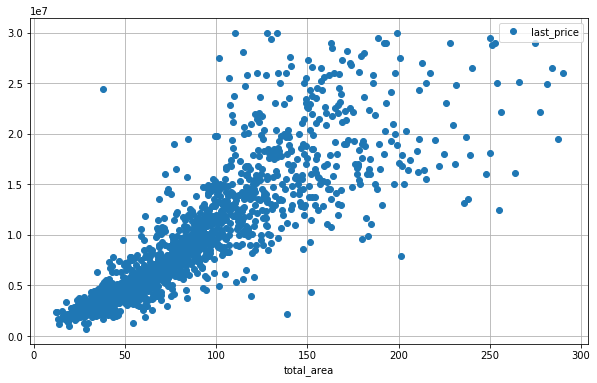

In [470]:
# В этой части я строю все графики вручную, т.к. это дало более наглядные результаты, 
# чем автоматическое построение в цикле. Цикл буду применять при сравнении этих результатов
# с результатами в центре города.

(data_filt
 .pivot_table(index='total_area',values='last_price',aggfunc='mean')
 .plot(grid=True, style='o', figsize=(10, 6))
)
plt.show()

# В данном случае, вероятно, нагляднее будет график типа  bar, но юпитер отказывается его строить и зависает.
# Возможно, дело в мощности сервера или что-то вроде того. Тем не менее, и из точечного графика видна
# искомая зависимость

Наблюдаем, в целом, ожидаемую зависимость - с росто площади квартиры увеличивается её цена. Причём в сегменте маленьких квартир эта зависимость более выражена в сравнении с более крупными квартирами.

#### Зависимость цены от количества комнат

Определим зависимость цены квадратного метра от количества комнат

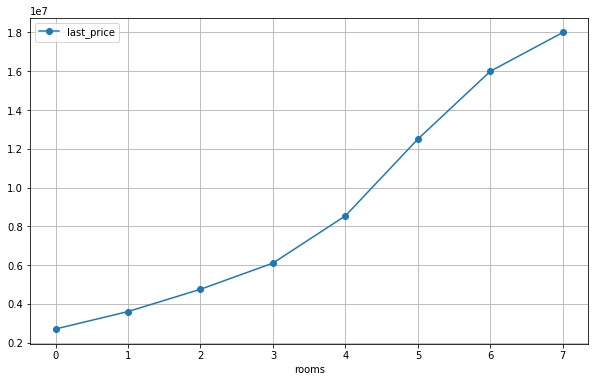

In [471]:
(data_filt
 .pivot_table(index='rooms',values='last_price',aggfunc='median')
 .plot(grid=True, style='o-', figsize=(10,6))
)
plt.show()

Видим чёткую зависимость - чем больше в квартире комнат, тем она дороже.

#### Зависимость цены от удалённости от центра

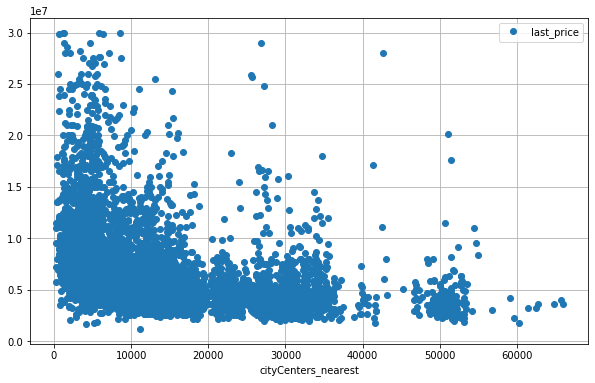

In [472]:
(data_filt
 .pivot_table(index='cityCenters_nearest',values='last_price',aggfunc='median')
 .plot(kind='line', style='o', grid=True, figsize=(10, 6))
)
plt.show()

# В данном случае, вероятно, нагляднее будет график типа  bar, но юпитер отказывается его строить и зависает.
# Возможно, дело в мощности сервера или что-то вроде того. Тем не менее, и из точечного графика можно примерно
# определить искомую зависимость.

Наблюдаем логичную зависимость - с ростом удалённости от центра средняяя стоимость квартиры. В центре города присутствуют значительно более дорогие предложения.

#### Зависимость цены от этажа

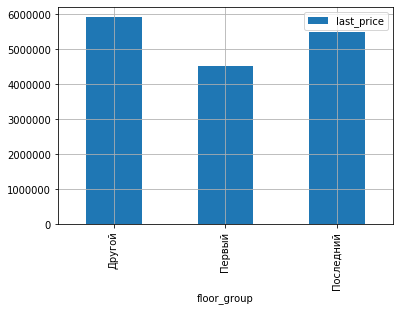

In [473]:
# В данном случае считаю гистограмму более наглядной

(data_filt
 .pivot_table(index='floor_group',values='last_price',aggfunc='mean')
 .plot(kind='bar', grid=True, figsize=(6, 4))
)
plt.show() 

Наблюдаем зависимость - квартиры на первом этаже дешевле всего, квартиры на последнем этаже более ценны. Наиболее высокую цену имеют квартиры на "средних" этажах.

#### Зависимость от дня размещения

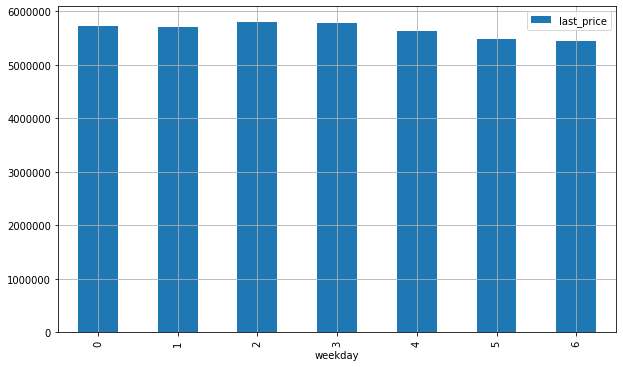

In [474]:
(data_filt
 .pivot_table(index='weekday', values='last_price', aggfunc='mean')
 .plot(kind='bar', grid=True, figsize=(10, 6))
)
plt.show()

На гистограмме разница ненаглядна, попробуем посмотреть на графике:

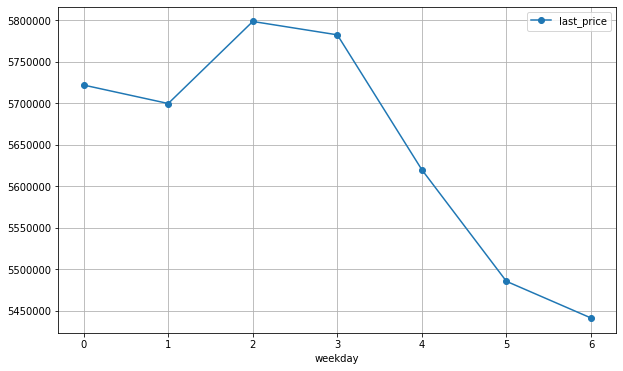

In [475]:
(data_filt
 .pivot_table(index='weekday', values='last_price', aggfunc='mean')
 .plot(kind='line', style='o-', grid=True, figsize=(10, 6))
)
plt.show()

Наблюдаем некоторое удорожание объявлений в середине недели и удешевление ближе к выходным. Разброс между крайними значениями около 6%. Это интересное наблюдение, возможно, стоит изучения.

#### Зависимость от месяца размещения

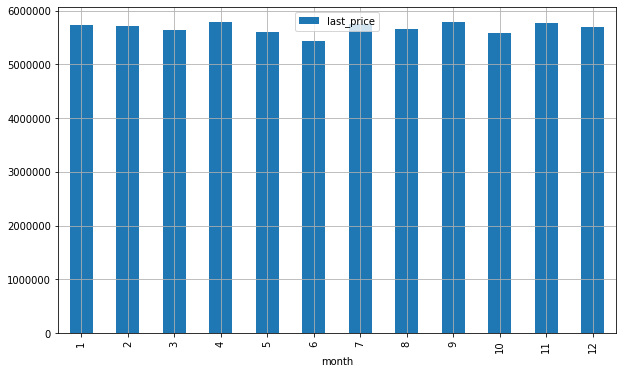

In [476]:
(data_filt
 .pivot_table(index='month', values='last_price', aggfunc='mean')
 .plot(kind='bar', grid=True, figsize=(10, 6))
)
plt.show()

Вновь зависимость на гистограмме не видна. Посмотрим на графике:

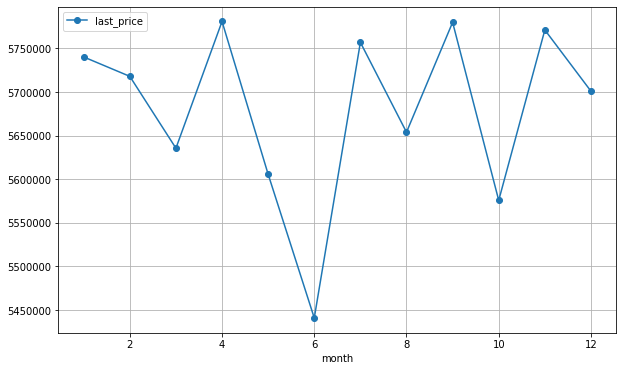

In [477]:
(data_filt
 .pivot_table(index='month', values='last_price', aggfunc='mean')
 .plot(kind='line', style='o-', grid=True, figsize=(10, 6))
)
plt.show()

Наблюдаем некоторую  зависимость: объявления, размещённые в июне и в октябре имеют меньшую цену (около 4%) в сравнении с объявлениями, размещёнными в апреле и в сентябре. Этот факт может стать предметом изучения.

#### Зависимость цены от года

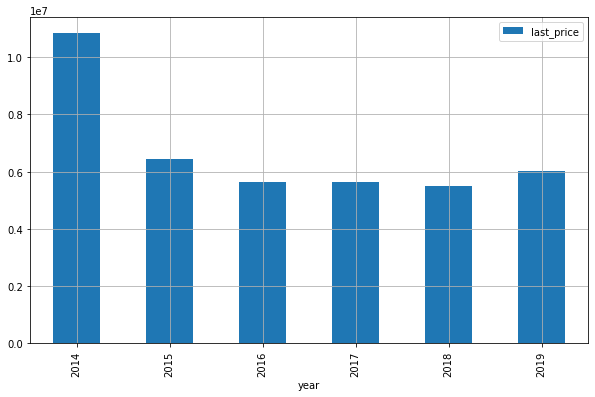

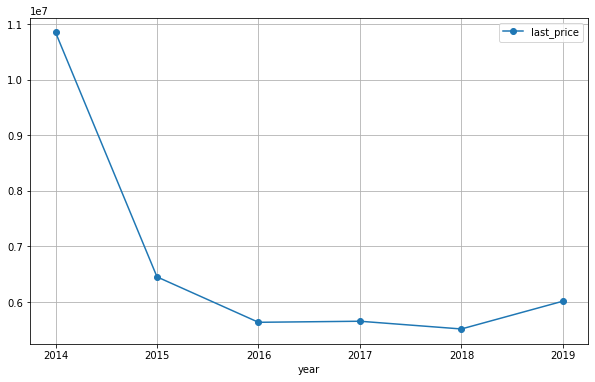

In [478]:
(data_filt
 .pivot_table(index='year', values='last_price', aggfunc='mean')
 .plot(kind='bar', grid=True, figsize=(10, 6)))
plt.show()

# Сразу посмотрим результат также на графике
(data_filt
 .pivot_table(index='year', values='last_price', aggfunc='mean')
 .plot(kind='line', style='o-',grid=True, figsize=(10, 6))
)
plt.show()

Наблюдаем значительное снижение цен на квартиры после 2014 года - почти 50%, к 2019 году намечается незначительный подъём. Можно предположить, что это связано с внутренним кризисом в России и снижением покупательской способности потенциальных клиентов, и, соответственно, спроса на дорогое жильё.

Для составления вывода по разделу добавим анализ корреляции значений:

In [479]:
column_list_corr = ['total_area','rooms','cityCenters_nearest','floor','weekday','month','year']

for column in column_list_corr:
    print(column, round(data_filt[column].corr(data_filt['last_price']),2))

total_area 0.79
rooms 0.51
cityCenters_nearest -0.35
floor 0.08
weekday -0.02
month 0.0
year -0.02


Анализ корреляции показывает, что в наибольшей степени цена квартиры зависит от её площади и количеста комнат, меньшая зависимость от этажа и удаления от центра. Зависимость от даты размещения отличается от пропорциональной - корреляция в данном случае непоказательна.

### Вывод по зависимости цены от различных факторов

Стоимость квартир больше всего зависит от следующих факторов:
1. Площадь квартиры (больше - дороже)
2. Количество комнат (больше - дороже)
3. Год размещения (скорее всего, влияние кризиса)

Менее значимая зависимость:
1. Удалённость от центра (дальше от центра - дешевле)
2. Этаж квартиры (первый, последний или "средний")

Интересные закономерности найдены в зависимости:
1. День размещения (снижение к выходным)
2. Месяц размещения (снижение в июне и октябре, рост в апреле и сентябре)

### 10 населённых пунктов с наибольшим числом объявлений

In [480]:
# Создадим таблицу, включающую 10 наиболее распространённых регионов

top10_places = (data_filt
                .pivot_table(index='locality_name', 
                                     values='sqm_price',
                                     aggfunc='count')
                .sort_values('sqm_price', ascending=False)
                .head(10)
               )

# Из всего датасета выделим объявления о квартирах в этих регионах

data_top10 = (data_top10
              .query('locality_name in @top10_places_list.index')
              .pivot_table(index='locality_name',
                                    values='sqm_price',
                                    aggfunc='mean')
              .sort_values('sqm_price', ascending=False)
             )
data_top10

,sqm_price
locality_name,
Санкт-Петербург,110437.026492
Пушкин,103099.285230
деревня Кудрово,92614.779090
посёлок Парголово,90019.817279
посёлок Мурино,85819.549951
посёлок Шушары,78651.548828
Колпино,75262.861444
Гатчина,68866.795319
Всеволожск,68773.176179


Ожидаемо, из наиболее популярных регионов самый дорогой м2 в Петербурге, далее идут Пушкин и деревня Кудрово. Самая дешёвая жилплощадь в Гатчине, Всеволожске и Выборге.

Оценим наиболее дорогие и дешёвые регионы без привязки к количеству объявлений:

In [481]:
# Весь датасет, отсортированный по средней стоимости м2
data_price_sorted = (data_filt                  
                    .pivot_table(index='locality_name',
                                    values='sqm_price',
                                    aggfunc='mean')
                      .sort_values('sqm_price', ascending=False)
                    )
# Самые дорогие регионы
data_price_sorted.head(5)

,sqm_price
locality_name,
посёлок Лисий Нос,168706.697460
Зеленогорск,115122.799198
Санкт-Петербург,110437.026492
посёлок Репино,104238.614786
Пушкин,103099.285230


In [482]:
# И самые дешёвые
data_price_sorted.tail(5)

,sqm_price
locality_name,
поселок Совхозный,12629.129129
деревня Выскатка,12335.480902
деревня Вахнова Кара,11688.311688
посёлок станции Свирь,11481.481481
деревня Старополье,11206.221198


### Квартиры в Санкт-Петербурге

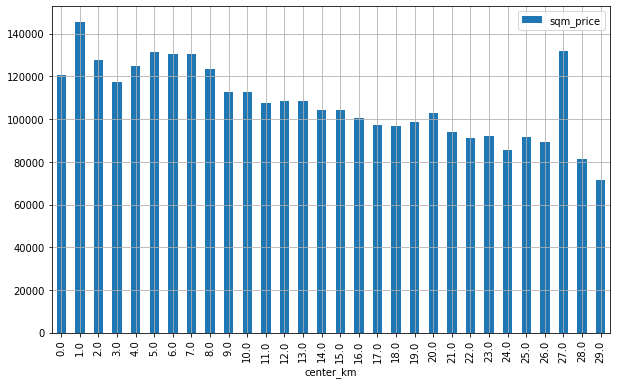

In [483]:
# Создадим столбец с расстоянием до центра Питера в километрах:
data_filt['center_km'] = round(data_filt['cityCenters_nearest'] / 1000)

# Выделим квартиры в Питере:
data_spb = data_filt.query('locality_name == "Санкт-Петербург" ')

# Построим гистограмму, чтобы определить границу центра
((data_spb
  .pivot_table(index='center_km',values='sqm_price',aggfunc='mean')
  .plot(kind='bar', grid=True, figsize=(10, 6))))
plt.show()

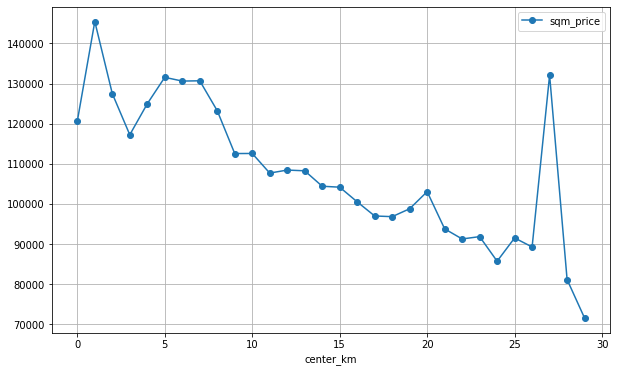

In [484]:
# Для бОльшей наглядности также посмотрим график:

((data_spb
  .pivot_table(index='center_km',values='sqm_price',aggfunc='mean')
  .plot(kind='line', style='o-', grid=True, figsize=(10, 6))))
plt.show()

Опирась на данные гистограммы и графика, а также на изучение карты Петербурга с включением центральных районов принимаем границу центра равную 8 километрам. Сделаем срез:

In [485]:
data_spb_center = data_spb.query('center_km <= 8')

### Изучение квартир в центре

Изучим параметры площади, цены, количества комнат и высоту потолков в квартирах в центре.

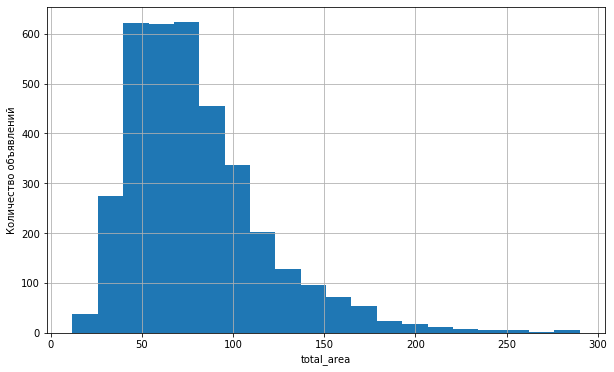

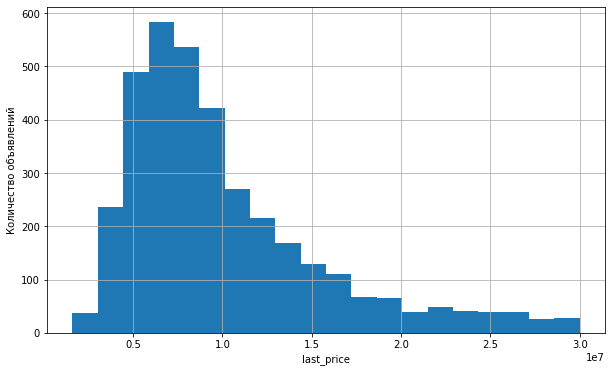

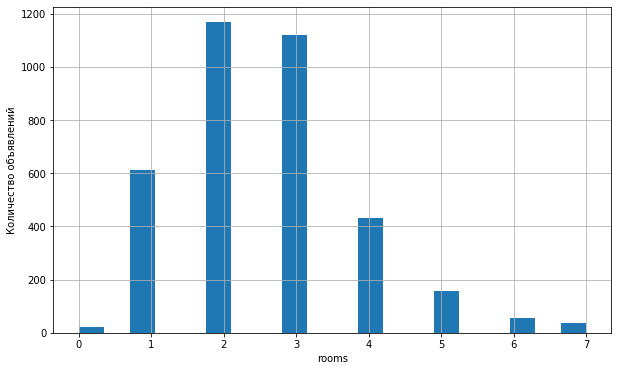

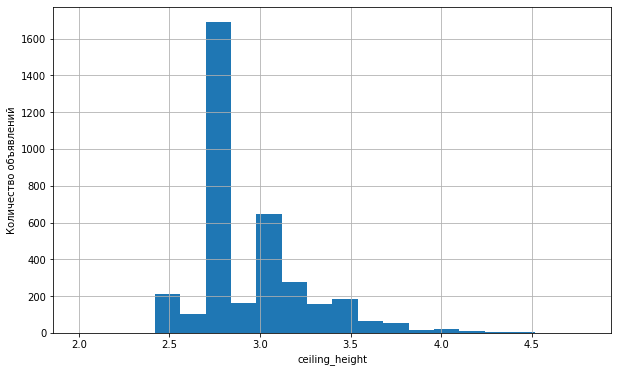

In [486]:
# В данном анализе применяю автоматическое построение графиков, т.к. ожидаемая картина уже получена ранее:

column_list_center_hist = ['total_area','last_price','rooms','ceiling_height']

for column in column_list_center_hist:
    data_spb_center[column].hist(bins=20,figsize=(10,6))
    plt.xlabel(column)
    plt.ylabel('Количество объявлений')
    plt.show()

Сравним полученные результаты по квартирам в центре Петербурга со всей Ленинградской областью:
1. Средняя площадь квартир совпадает - от 25 до 100 м2
2. Квартиры в центре дороже - наиболее распространены от 5 до 15 млн руб., пик приходится на 6..7 млн руб.
3. 2- и 3-комнатные квартиры в центре более популярны, чем 1-комнатные.
4. Основная масса квартир имеет потолки 2.7 метра, однако доля 3-метровых заметно выше.

#### Изучим зависимость цены от различных факторов

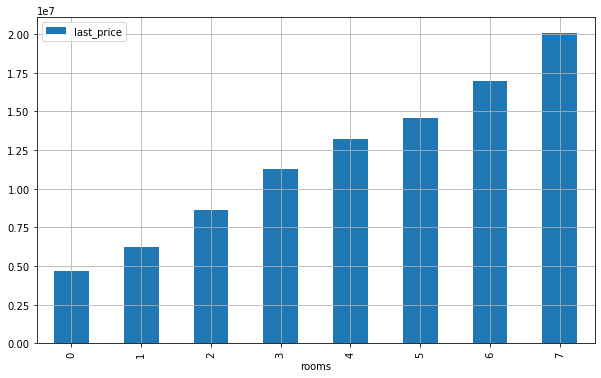

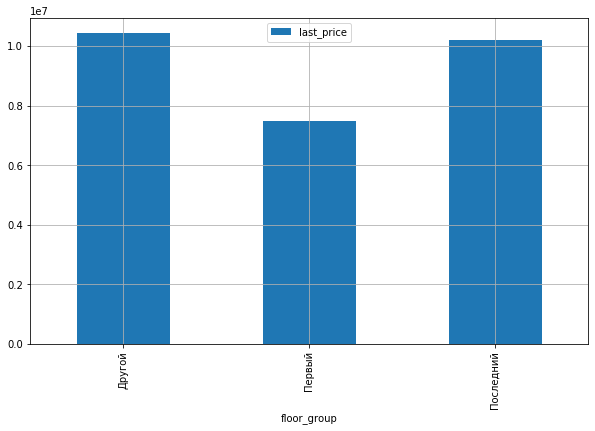

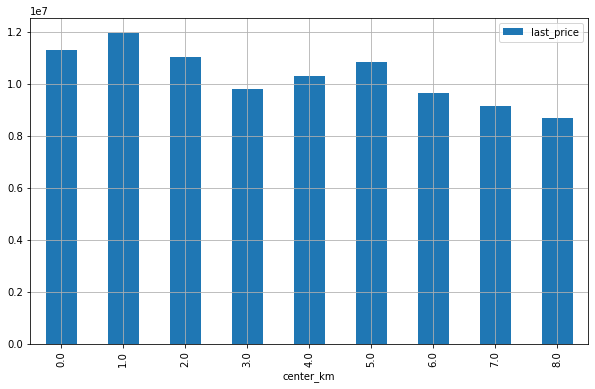

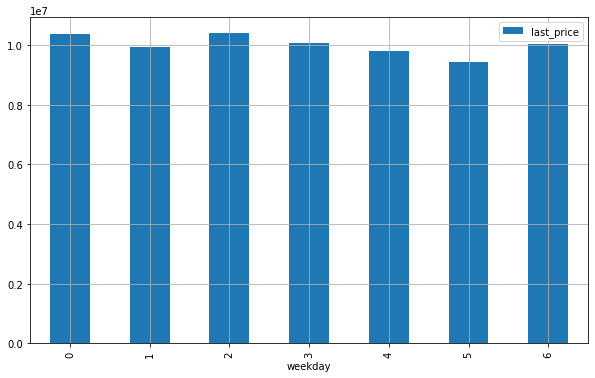

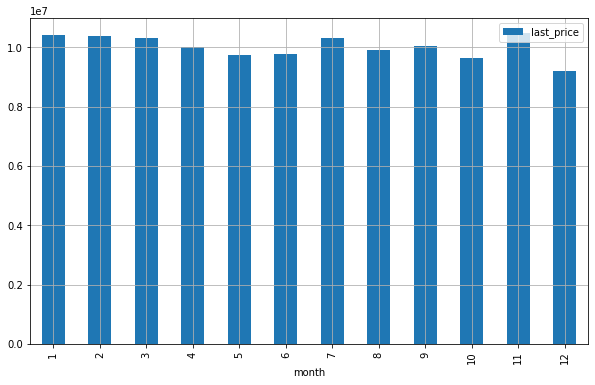

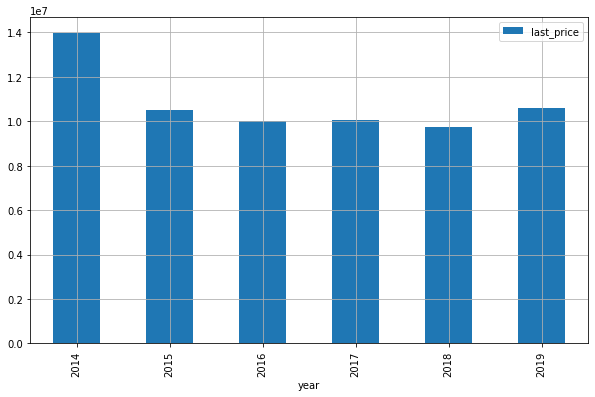

In [487]:
column_list_center_factors = ['rooms','floor_group','center_km','weekday','month','year']

for column in column_list_center_price:
    (data_spb_center.pivot_table(index=column, values='last_price', aggfunc='mean').
     plot(kind='bar', grid=True, figsize=(10, 6)))
    plt.show()

Дополнительно добавим оценку корелляции:

In [488]:
column_list_center_corr = ['total_area','rooms','center_km','floor','weekday','month','year']

for column in column_list_center_corr:
    print(column, round(data_spb_center[column].corr(data_spb_center['last_price']),2))

total_area 0.75
rooms 0.49
center_km -0.13
floor 0.17
weekday -0.03
month -0.03
year -0.01


Картина корреляции в целом похожа на данные по всей Ленинградской области

#### Вывод по отличию зависимости цен квартир в центре от разных фактором

Картина в центре и в области мало меняется при рассмотрении следующих факторов:
1. Площадь квартиры.
2. Количество комнат.

Заметно различие:
1. Квартиры на последнем этаже ценятся примерно так же, как и на "средних" этажах.
2. Падение стоимости квартир после 2014 года примерно на 30-40% менее значительное, чем в области.

### Шаг 5. Общий вывод

В ходе проекта проделаны выполнены следующие этапы и получены выводы:
1. Проведена обработка данных, заполнены пропуски и отброшены выбивающиеся значения.
2. Изучено количественное распределение объявлений в зависимости от различных факторов.
3. Определены факторы, влияющие на стоимость квартир, и степень их влияния.
4. Отдельно выделен центральный район Петербурга и сделаны выводы о различиях квартир в центре города от квартир в области.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. 
- [x]  "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод